## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


In [427]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import unicodedata
import re
from bs4 import BeautifulSoup

# www.topuniversities.com

## Methodology

<span style="color:blue">After examing the webpage, we identify the URL of a JSON file that contains the ranking. Working with JSON is much simpler than working with HTML, so we perform an HTTP GET on that URL, providing a suitable timestamp value (`?_=...`). We then parse the JSON and extract the information we are interested in.</span>  

<span style="color:blue">As indicated in the problem statement, some stats are not available in the main list. We visit each university URL to extract the missing stats and scrap the HTML using BeautifulSoup.  

<span style="color:blue">Finally, we put all this data in a dataframe</span>

In [428]:
BASE_URL_TOP = 'https://www.topuniversities.com'
RANKING_URL_TOP = '/sites/default/files/qs-rankings-data/357051.txt?_=%d'

In [429]:
# Helper function to extract a metric using a CSS selector
def extract_metric(soup, selector):
    try:
        return int(soup.select(selector)[0].get_text().replace(',', ''))
    except:
        return None

# Function to obtain and format the top n universities in the ranking
def get_list_top(n=200):
    # Request the JSON data
    timestamp = int(time.time() * 1000)
    r = requests.get((BASE_URL_TOP + RANKING_URL_TOP) % timestamp)
    raw_ranking = r.json()['data'][0:n]
    
    # Process and clean each entry in the ranking, fetching the detailed page and extracting the necessary information
    ranking = []
    for entry in raw_ranking:
        rank = int(entry['rank_display'].replace('=', '')) # drop the = for tied ranks
        name = entry['title']
        country = entry['country']
        region = entry['region']
        r = requests.get(BASE_URL_TOP + entry['url'])
        soup = BeautifulSoup(r.text, 'lxml')
        total_students = extract_metric(soup, 'div.total.student .number')
        total_int_students = extract_metric(soup, 'div.total.inter .number')
        total_faculty = extract_metric(soup, 'div.total.faculty .number')
        total_int_faculty = extract_metric(soup, 'div.inter.faculty .number')
        ranking.append({'rank': rank, 'name': name, 'country': country, 'region': region, 'total_students': total_students, 'total_int_students': total_int_students, 'total_faculty': total_faculty, 'total_int_faculty': total_int_faculty})        
    
    # Create the dataframe and index it
    df = pd.DataFrame(ranking)
    df = df.set_index('rank')
    df = df.reindex_axis(['name', 'country', 'region', 'total_students', 'total_int_students', 'total_faculty', 'total_int_faculty'], axis=1)
    return df
    
# Let's see what it looks like for the five top universities...
top_df = get_list_top()
top_df.head()

,name,country,region,total_students,total_int_students,total_faculty,total_int_faculty
rank,,,,,,,
1,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,3717.0,2982.0,1679.0
2,Stanford University,United States,North America,15878.0,3611.0,4285.0,2042.0
3,Harvard University,United States,North America,22429.0,5266.0,4350.0,1311.0
4,California Institute of Technology (Caltech),United States,North America,2255.0,647.0,953.0,350.0
5,University of Cambridge,United Kingdom,Europe,18770.0,6699.0,5490.0,2278.0


Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

### Best universities in term of ratio between faculty members and students

,name
rank,
4,California Institute of Technology (Caltech)
16,Yale University
6,University of Oxford
5,University of Cambridge
17,Johns Hopkins University
2,Stanford University
1,Massachusetts Institute of Technology (MIT)
186,University of Rochester
19,University of Pennsylvania


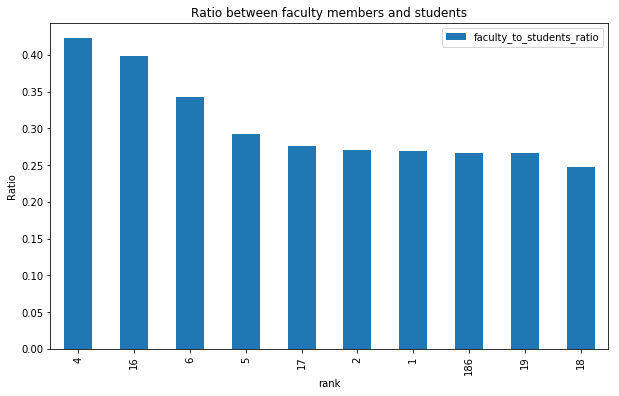

In [430]:
df = top_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
highest_faculty_to_student = df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'faculty_to_students_ratio']]

p1 = highest_faculty_to_student.plot(kind='bar',title='Ratio between faculty members and students',figsize=(10,6))
p1.set_ylabel("Ratio")

highest_faculty_to_student[['name']]

<span style="color:blue">The graph above provides the ratio of faculty members to student according to ranking. The ten highest ratios are put in the bar plot. One can see that 5 of the 10 top ranked universities are shown which supposes a link between the ranking and this ratio. It can also be seen that the best university in these terms is California Institute of Technology (Caltech). </span>

### Best universities in term of ratio of international students

,name
rank,
35,London School of Economics and Political Scien...
12,Ecole Polytechnique Fédérale de Lausanne (EPFL)
8,Imperial College London
200,Maastricht University
47,Carnegie Mellon University
7,UCL (University College London)
92,University of St Andrews
41,The University of Melbourne
127,Queen Mary University of London


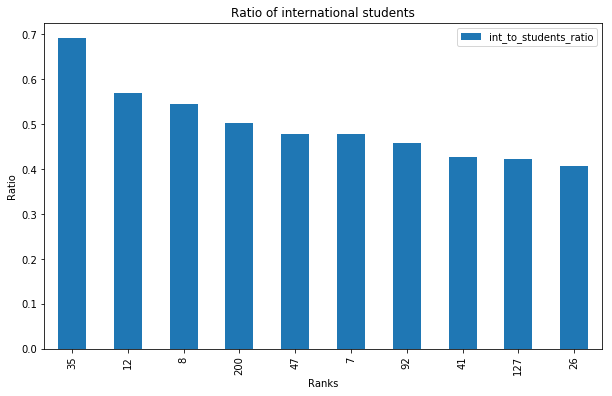

In [431]:
df = top_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
highest_int_students = df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'int_to_students_ratio']]
p2 = highest_int_students.plot(kind='bar',title='Ratio of international students',figsize=(10,6))
p2.set_ylabel("Ratio")
p2.set_xlabel("Ranks")
highest_int_students[['name']]

<span style="color:blue">This bar plot represents the ten highest ratios of international students. 7 over the ten present universities are in the top 50 rank. It seems that the presence of internationality leads to a better rank. The best university in terms of international students is London School of Economics and Political Science. </span>

### Best universities in term of ratio between faculty members and students by country

In [432]:
country_df = top_df.copy()
country_df = country_df.groupby('country').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum', 'total_int_faculty': 'sum'})

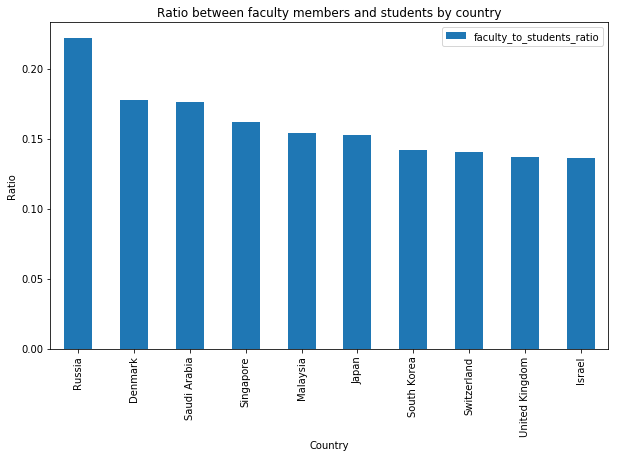

In [433]:
df = country_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
country_faculty_to_student = df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['faculty_to_students_ratio']]
p3 = country_faculty_to_student.plot(kind='bar',title='Ratio between faculty members and students by country',figsize=(10,6))
p3.set_ylabel("Ratio")
p3.set_xlabel("Country")

<span style="color:blue">Here the bar plot represents the 10 highest ratios of faculty members over students by country. It is clearly observable that Russia has the most faculty members compared to the number of students. </span>

name                  9
country               9
region                9
total_students        9
total_int_students    9
total_faculty         9
total_int_faculty     9
dtype: int64

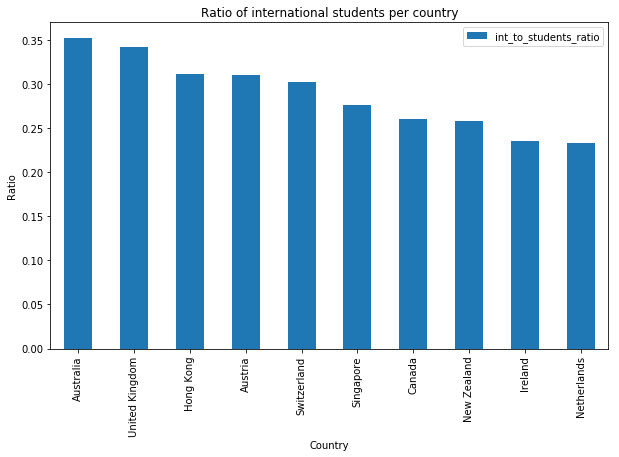

In [434]:
df = country_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
country_int_to_students = df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['int_to_students_ratio']]

p4 = country_int_to_students.plot(kind='bar',title='Ratio of international students per country',figsize=(10,6))
p4.set_ylabel("Ratio")
p4.set_xlabel("Country")

top_df.query("country == 'Australia'").count()


<span style="color:blue">The 10 biggest ratios of international students can be observed on the graph represented above. Australia is the country that has the most international students.</span>

### Best universities in term of ratio between faculty members and students by region

In [435]:
region_df = top_df.copy()
region_df = region_df.groupby('region').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum', 'total_int_faculty': 'sum'})

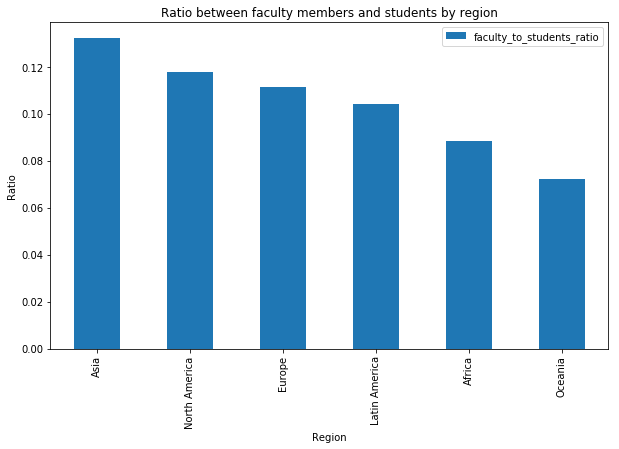

In [436]:
df = region_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
region_faculty_to_student = df.sort_values('faculty_to_students_ratio', ascending=False).loc[:, ['faculty_to_students_ratio']]

p5 = region_faculty_to_student.plot(kind='bar',title='Ratio between faculty members and students by region',figsize=(10,6))
p5.set_ylabel("Ratio")
p5.set_xlabel("Region")


<span style="color:blue">By representing the ratio between faculty members and the number of students by region, it can be seen that Asia is the region where this ratio is the highest. </span>

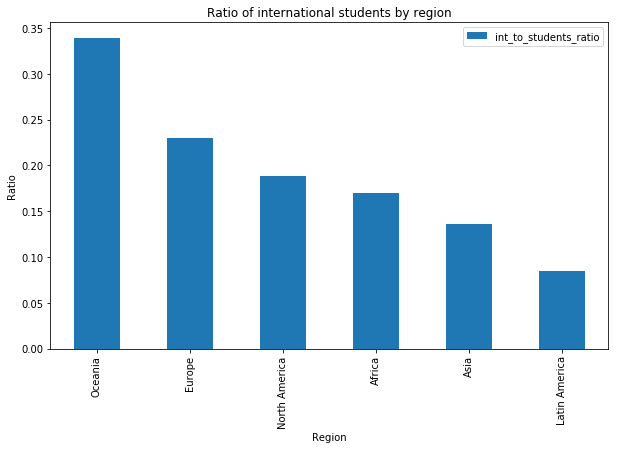

In [437]:
df = region_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
region_int_to_students = df.sort_values('int_to_students_ratio', ascending=False).loc[:, ['int_to_students_ratio']]

p6 = region_int_to_students.plot(kind='bar',title='Ratio of international students by region',figsize=(10,6))
p6.set_ylabel("Ratio")
p6.set_xlabel("Region")

<span style="color:blue">The graph above represents the ratio of international students by region. The best region according to this criteria is Oceania.</span>

# www.timeshighereducation.com

## Methodology

<span style="color:blue">We also identify the URL of a JSON file that contains the ranking for this dataset and proceed a similar way as for the previous one. It appears that the JSON file contains everything we are interested in, but the number of international faculty and the region. However, since the detailed pages for each university does not contain this information either, there is no point in using BeautifulSoup to extract data from there.</span>

In [438]:
RANKING_URL_TIMES = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [439]:
# Function to obtain and format the top n universities in the ranking
def get_list_times(n=200):
    # HTTP GET to fetch the data
    r = requests.get(RANKING_URL_TIMES)
    raw_ranking = r.json()['data']
    
    # Process and clean each entry in the ranking
    ranking = []
    for entry in raw_ranking[0:n]:
        rank = int(entry['rank'].replace('=', '')) # drop the = for tied ranks
        name = entry['name']
        country = entry['location']
        total_students = int(entry['stats_number_students'].replace(',', ''))
        total_int_students = int(float(entry['stats_pc_intl_students'].replace('%', '')) / 100.0 * total_students)
        total_faculty = int(total_students / float(entry['stats_student_staff_ratio']))
        ranking.append({'rank': rank, 'name': name, 'country': country, 'total_students': total_students, 'total_int_students': total_int_students, 'total_faculty': total_faculty})   
    
    # Create a dataframe and index it
    df = pd.DataFrame(ranking)
    df = df.set_index('rank')
    df = df.reindex_axis(['name', 'country', 'total_students', 'total_int_students', 'total_faculty'], axis=1)
    return df

# Let's see what this one looks like
times_df = get_list_times()
times_df.head()

,name,country,total_students,total_int_students,total_faculty
rank,,,,,
1,University of Oxford,United Kingdom,20409,7755,1822
2,University of Cambridge,United Kingdom,18389,6436,1687
3,California Institute of Technology,United States,2209,596,339
3,Stanford University,United States,15845,3485,2112
5,Massachusetts Institute of Technology,United States,11177,3800,1284


<span style="color:blue">As we can see, that dataframe does not contain the region. However, we can infer the region using the data from the first dataframe.

<span style="color:blue">Let's build a mapping from country to region using the first dataframe...</span>

In [440]:
countries_regions_df = top_df.copy().reset_index().loc[:, ['country', 'region']].drop_duplicates()
# Let's add a couple missing ones
countries_regions_df = pd.concat([countries_regions_df, pd.DataFrame([['Russian Federation', 'Europe'], ['Luxembourg', 'Europe']], columns=['country', 'region'])])

<span style="color:blue">... And join that mapping with the times dataframe to get the region column filled in.</span>

In [441]:
times_df = times_df.reset_index().merge(countries_regions_df)
times_df['rank'].astype(int)
times_df = times_df.set_index('rank')
times_df.reindex_axis(['name', 'country', 'region', 'total_students', 'total_int_students', 'total_faculty'], axis=1)
times_df = times_df.sort_index()

# Let's see what it looks like...
times_df.head()

,name,country,total_students,total_int_students,total_faculty,region
rank,,,,,,
1,University of Oxford,United Kingdom,20409,7755,1822,Europe
2,University of Cambridge,United Kingdom,18389,6436,1687,Europe
3,Stanford University,United States,15845,3485,2112,North America
3,California Institute of Technology,United States,2209,596,339,North America
5,Massachusetts Institute of Technology,United States,11177,3800,1284,North America


Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

### Best universities in term of ratio between faculty members and students

,name
rank,
105,Vanderbilt University
109,University of Copenhagen
13,Johns Hopkins University
12,Yale University
153,University of Rochester
98,Emory University
17,Duke University
115,École Polytechnique
184,Scuola Normale Superiore di Pisa


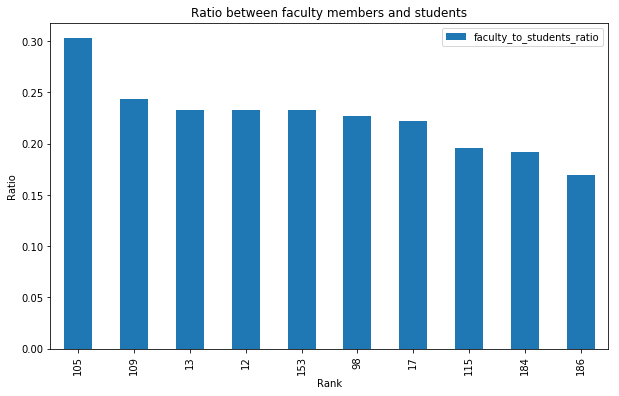

In [442]:
df = times_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
highest_faculty_to_student_times = df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'faculty_to_students_ratio']]


p7 = highest_faculty_to_student_times.plot(kind='bar',title='Ratio between faculty members and students',figsize=(10,6))
p7.set_ylabel("Ratio")
p7.set_xlabel("Rank")

highest_faculty_to_student_times[['name']]

<span style="color:blue">According to the ranking on Times, 4 universities on the top 100 are present in this graph. It seems that this ratio has less influence on increasing the ranking compared to Top universities ranking. </span>

,name
rank,
25,London School of Economics and Political Science
179,University of Luxembourg
8,Imperial College London
38,École Polytechnique Fédérale de Lausanne
103,Maastricht University
16,University College London
143,University of St Andrews
24,Carnegie Mellon University
121,Queen Mary University of London


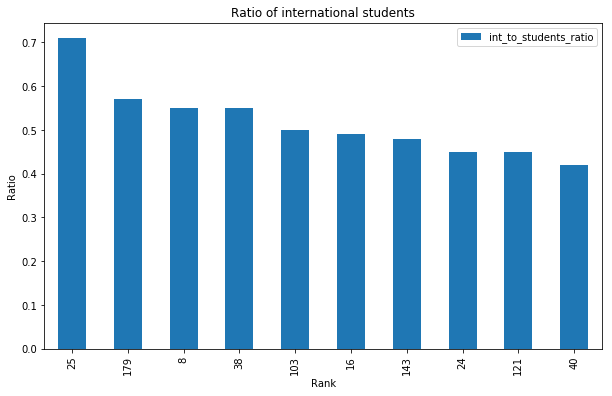

In [443]:
df = times_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
highest_int_to_students_times = df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'int_to_students_ratio']]

p8 = highest_int_to_students_times.plot(kind='bar',title='Ratio of international students',figsize=(10,6))
p8.set_ylabel("Ratio")
p8.set_xlabel("Rank")

highest_int_to_students_times[['name']]

<span style="color:blue">Here 6 universities from the top 100 ranks are present. It seems that the ratio of international students has an influence on increasing the ranking.</span>

### Best universities in term of ratio between faculty members and students by country

In [444]:
country_df = times_df.copy()
country_df = country_df.groupby('country').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum'})

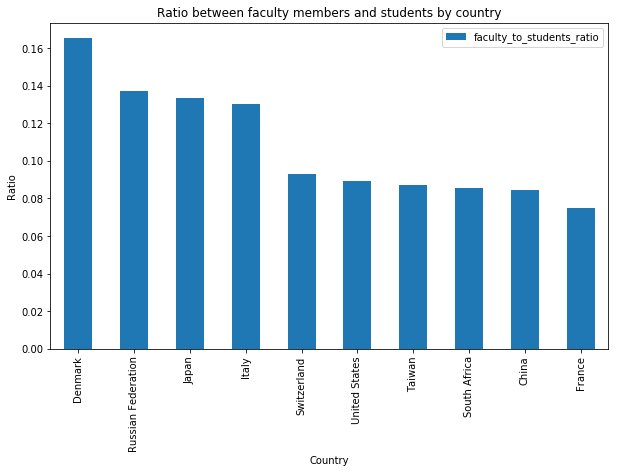

In [445]:
df = country_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
country_faculty_to_student_times = df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['faculty_to_students_ratio']]

p9 = country_faculty_to_student_times.plot(kind='bar',title='Ratio between faculty members and students by country',figsize=(10,6))
p9.set_ylabel("Ratio")
p9.set_xlabel("Country")


<span style="color:blue">The ratio between faculty members and students by country shows that Denmark has the highest ratio. The Russian Federation is the second.</span>

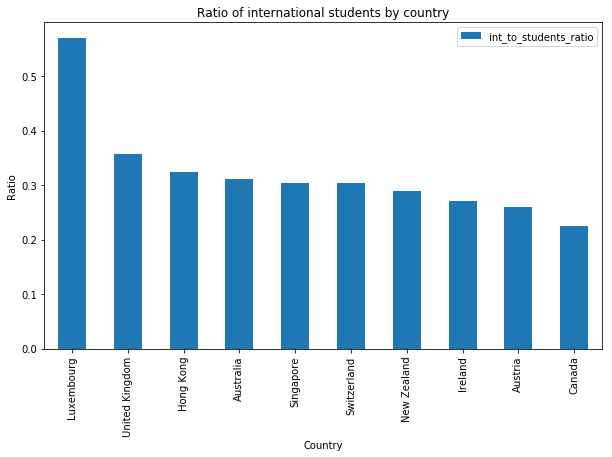

In [446]:
df = country_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
country_int_to_students_times = df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['int_to_students_ratio']]

p10 = country_int_to_students_times.plot(kind='bar',title='Ratio of international students by country',figsize=(10,6))
p10.set_ylabel("Ratio")
p10.set_xlabel("Country")

<span style="color:blue">In terms of international students, Luxembourg is the first. It should be mentioned that only one university from Luxembourg is on the ranking and this result may not be robust. </span>

### Best universities in term of ratio between faculty members and students by region

In [447]:
region_df = times_df.copy()
region_df = region_df.groupby('region').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum'})

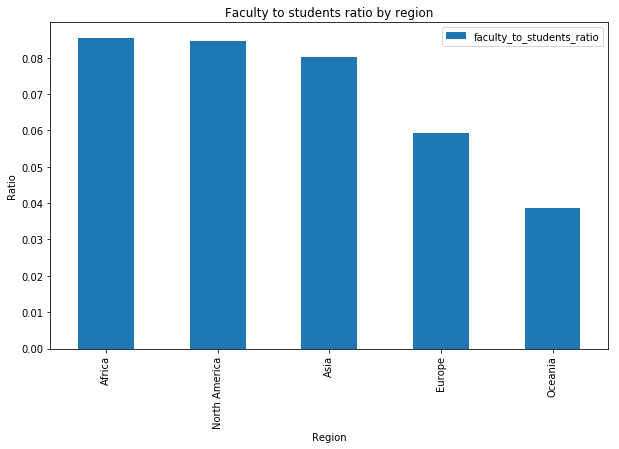

In [448]:
df = region_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
region_faculty_to_student_times = df.sort_values('faculty_to_students_ratio', ascending=False).loc[:, ['faculty_to_students_ratio']]

p11 = region_faculty_to_student_times.plot(kind='bar',title='Faculty to students ratio by region',figsize=(10,6))
p11.set_ylabel("Ratio")
p11.set_xlabel("Region")

<span style="color:blue">According to Times ranking, Africa is the first region in terms of faculty members over the number of students. This result is different from the one obtained for the topuniversities ranking where Asia was first in this category.</span>

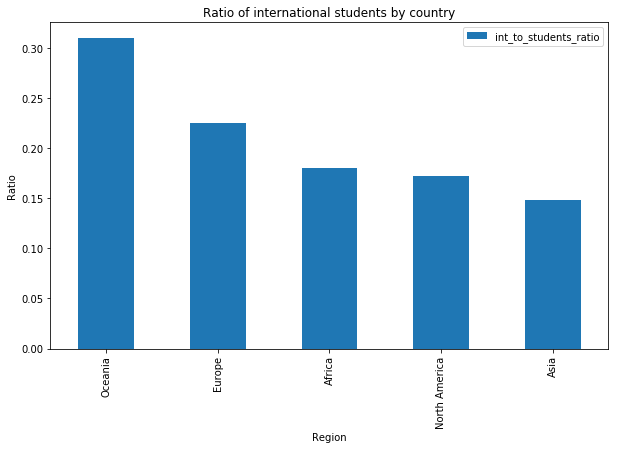

In [449]:
df = region_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
region_int_to_students_times = df.sort_values('int_to_students_ratio', ascending=False).loc[:, ['int_to_students_ratio']]

p12 = region_int_to_students_times.plot(kind='bar',title='Ratio of international students by country',figsize=(10,6))
p12.set_ylabel("Ratio")
p12.set_xlabel("Region")

<span style="color:blue">Oceania is the region which has the biggest ratio of international students. This result was also found in the previous ranking.</span>

# Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

We observe that university names can differ quite significantly between each ranking, so we opt for the following merging strategy:

1. Merge the two dataframes by country and region, effectively computing a filtered cartesian product of the two rankings.
2. Use a string similarity metric to estimate the similarity between the names in each ranking. We remove common words such as _University_, _of_, etc. to avoid confusing the metric.
3. Sort entries by decreasing similarity and pick one entry for each university name.
4. Filter out matchings with low similarity. We opt for a similarity of >= 0.8 after careful examination of the results.

In [450]:
from difflib import SequenceMatcher

def clean_name(name):
    tmp = name
    for token in ['University', 'of', 'Institute', 'The', 'Technology']:
        tmp = tmp.replace(token, '')
    return tmp.strip()

def similar(n1, n2):
    return SequenceMatcher(None, clean_name(n1), clean_name(n2)).ratio()

In [451]:
SIMILARITY_CUT = 0.8

In [452]:
df1 = top_df.copy()
df1 = df1.reset_index()
df2 = times_df.copy()
df2.loc[df2.country == 'Russian Federation', 'country'] = 'Russia' # Adjust Russia's name
df2 = df2.reset_index()

# Merge both dataframes on country and region
df = df1.merge(df2, on=['country', 'region'], suffixes=['_top', '_times'])

# Compute similarity
df['similarity'] = df[['name_top','name_times']].apply(lambda x: similar(*x), axis=1)

# Select each unique entry with the highest similarity, then filter out entries with too low similarity
merged_df = df.sort_values('similarity', ascending=False).groupby('name_times', as_index=False).first()
merged_df = merged_df.loc[merged_df.similarity >= SIMILARITY_CUT]

# Clean it up a little...
merged_df = merged_df[['name_times', 'country', 'region', 'rank_top', 'rank_times', 'total_students_top', 'total_int_students_top', 'total_faculty_top', 'total_int_faculty', 'total_students_times', 'total_int_students_times', 'total_faculty_times']].rename(columns = {'name_times':'name'})
merged_df = merged_df.set_index('name')
merged_df = merged_df.sort_index()

# Let's see what that looks like
merged_df

,country,region,rank_top,rank_times,total_students_top,total_int_students_top,total_faculty_top,total_int_faculty,total_students_times,total_int_students_times,total_faculty_times
name,,,,,,,,,,,
Aalto University,Finland,Europe,137,190,12147.0,1831.0,1257.0,370.0,12744,2548,630
Aarhus University,Denmark,Europe,119,109,26226.0,3762.0,2316.0,602.0,25167,3020,1759
Australian National University,Australia,Oceania,20,48,14442.0,5551.0,1600.0,927.0,15986,5595,828
Boston University,United States,North America,81,70,25662.0,7041.0,3157.0,379.0,24833,6208,2887
Brown University,United States,North America,53,50,9251.0,1825.0,1303.0,379.0,8898,1779,831
Cardiff University,United Kingdom,Europe,137,162,24565.0,6090.0,2755.0,705.0,24186,6288,1791
Carnegie Mellon University,United States,North America,47,24,13356.0,6385.0,1342.0,425.0,12676,5704,938
Chinese University of Hong Kong,Hong Kong,Asia,46,58,18037.0,4824.0,2208.0,1074.0,18072,5602,1044
City University of Hong Kong,Hong Kong,Asia,49,119,9240.0,3273.0,1349.0,1027.0,9240,3234,825


<span style="color:blue">It appears our merging strategy managed to match 142 university names. Not bad...</span>

# Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

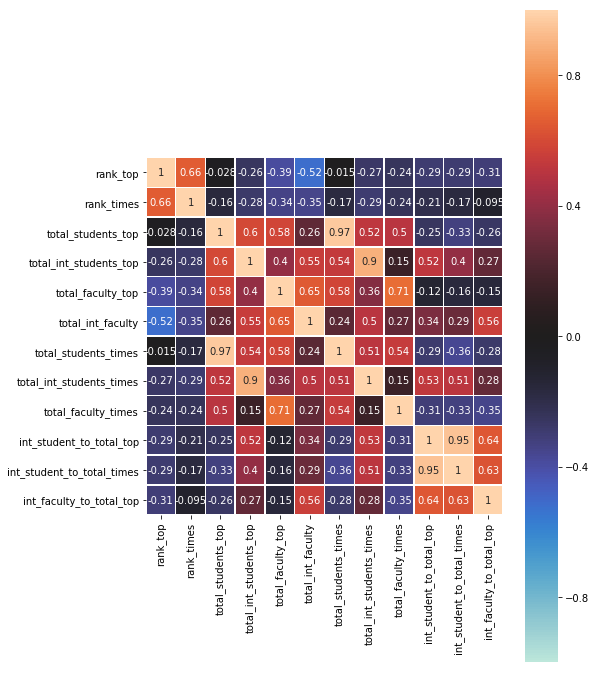

In [453]:
df_ratio = merged_df.copy()
df_ratio['int_student_to_total_top'] = df_ratio['total_int_students_top']/df_ratio['total_students_top']
df_ratio['int_student_to_total_times'] = df_ratio['total_int_students_times']/df_ratio['total_students_times']

df_ratio['int_faculty_to_total_top'] = df_ratio['total_int_faculty']/df_ratio['total_faculty_top']

correlations = df_ratio.corr()

plt.figure(figsize=(8, 12))
sns.heatmap(correlations, annot=True, center =0,square=True,linewidths=.5, vmax = 1.0, vmin = -1.0)

<span style="color:blue">The heatmap permits to have an overview on all the correlations. However it is difficult to separate strong correlations from weak ones. To have a better visualisation, the correlations are separated in 3 categories: </span>

* <span style="color:blue">Strong correlations that shows absolute correlations values between 1 and 0.5 </span>
* <span style="color:blue"> Moderate correlations that shows absolute correlations values between 0.5 and 0.3 </span>
* <span style="color:blue"> Weak correlations that shows absolute correlations values between 0.3 and 0.1 </span>



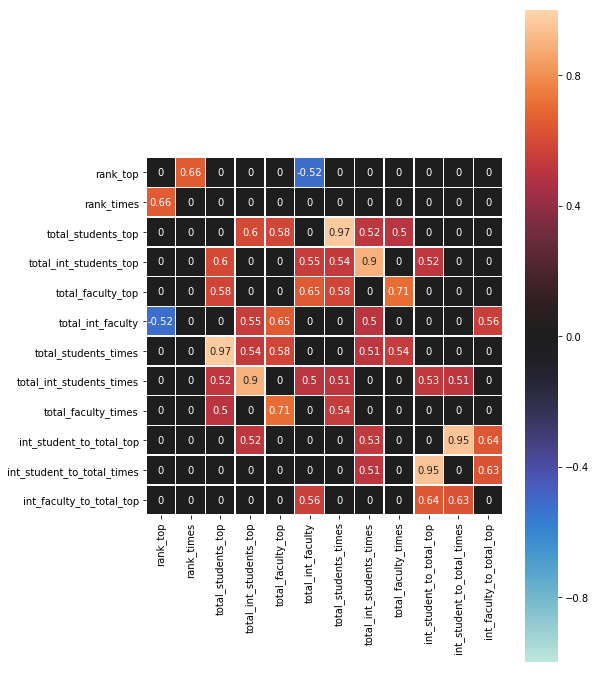

In [454]:
# Keep correlations smaller than 1 and abs(correlations) > 0.5
strong_correlations = correlations[((correlations >= 0.5) | (correlations <= -0.5)) & (correlations < 1)]
# Keep correlations smaller than 0.5 and abs(correlations) > 0.3
moderate_correlations = correlations[((correlations >= 0.3) | (correlations <= -0.3)) & (abs(correlations) < 0.5)]
# Keep correlations smaller than 0.3 and abs(correlations) > 0.1
weak_correlations = correlations[((correlations >= 0.1) | (correlations <= -0.1)) & (abs(correlations) < 0.3)]

strong_correlations = strong_correlations.replace(np.nan, 0)
moderate_correlations = moderate_correlations.replace(np.nan, 0)
weak_correlations = weak_correlations.replace(np.nan, 0)

# Only the strong correlations are non-zero, this permits a better visualization
plt.figure(figsize=(8, 12))
sns.heatmap(strong_correlations, annot=True, center =0,square=True,linewidths=.5, vmax = 1.0, vmin = -1.0)

<span style="color:blue"> Some interesting strong positive correlations are found between: </span>
* <span style="color:blue">The total number of students and the number of international students </span>
* <span style="color:blue">The number of international members in faculty and the number of international students </span>
* <span style="color:blue">The internal student ratio and international members in faculty ratio </span>
* <span style="color:blue">The ranking of Topuniversities and of Times. The two rankings are correlated and thus has some same criteria to do their classification. </span>

<span style="color:blue">An interesting strong negative correlation is found between:</span>
* <span style="color:blue">The ranking on top university and the number of international members in faculty</span>

<span style="color:blue">Negative correlations between ranking and another variable means that the rank will beb lower and thus better. It seems that the number of international members in faculty has a strong positive influence on ranking.</span>

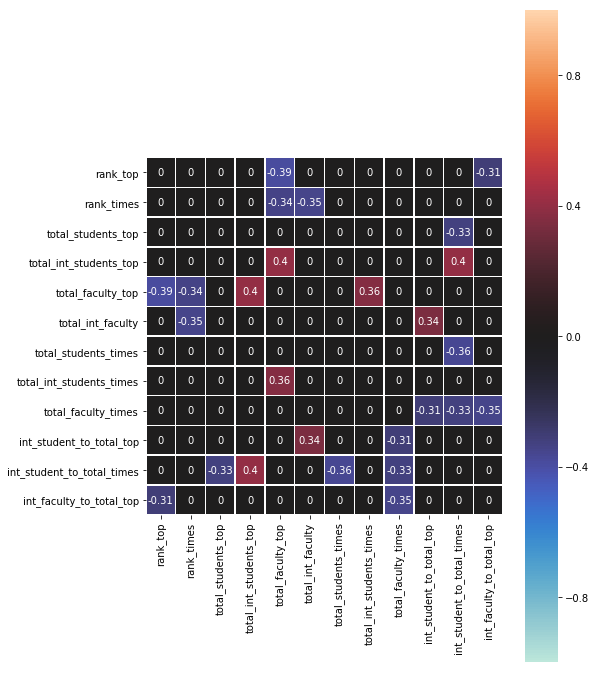

In [455]:
# Only the moderate correlations are non-zero, this permits a better visualization
plt.figure(figsize=(8, 12))
sns.heatmap(moderate_correlations, annot=True, center =0,square=True,linewidths=.5, vmax = 1.0, vmin = -1.0)

<span style="color:blue">On the heatmap presented above, it can be observed that the top ranking is negatively correlated to the ratio of international faculty members and to the total number of faculty members. As the correlation is negative, this means that the ranking is better with a highest ratio of international faculty memers and with a highest number of faculty members. Times ranking is positively influenced by the number of faculty members and by the number of international faculty members. </span>

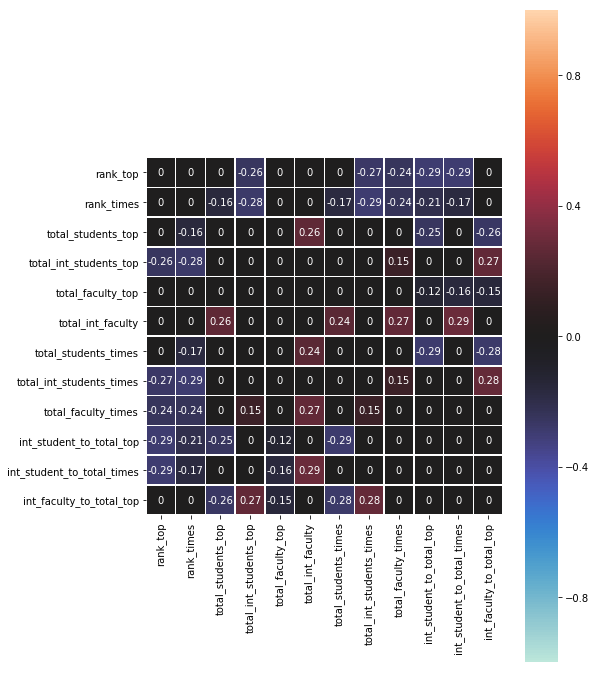

In [456]:
# Only the weak correlations are non-zero, this permits a better visualization
plt.figure(figsize=(8, 12))
sns.heatmap(weak_correlations, annot=True, center =0,square=True,linewidths=.5, vmax = 1.0, vmin = -1.0)

<span style="color:blue">It can be seen that there are weak correlations between ranking and: </span>
* <span style="color:blue">Total number of students</span>
* <span style="color:blue">Total number of international students</span>
* <span style="color:blue">Total number of faculty members</span>
* <span style="color:blue">Ratio of international students</span>

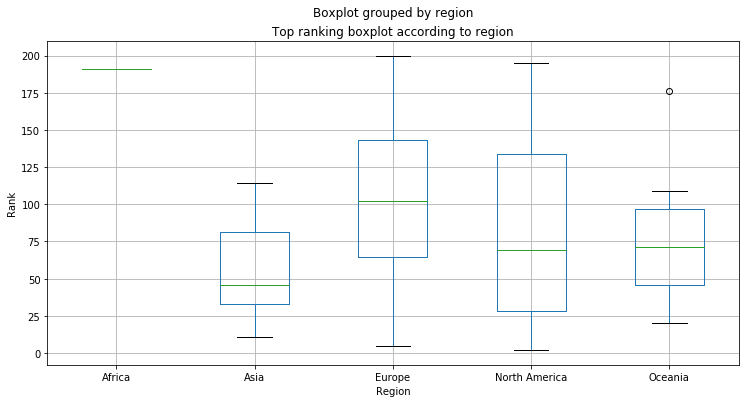

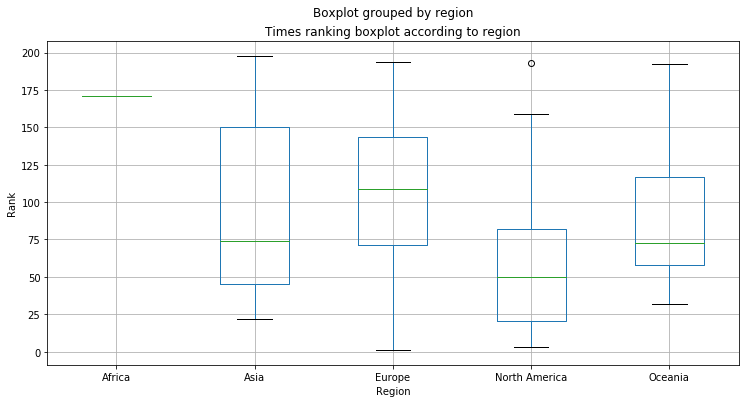

In [457]:
# Boxplots of ranking by regions

rank_region = merged_df.copy()

ax = rank_region.boxplot(column = ['rank_top'],by = 'region',figsize=(12,6))
ax.set_xlabel('Region')
ax.set_ylabel('Rank')
ax.set_title('Top ranking boxplot according to region')

ax = rank_region.boxplot(column = ['rank_times'],by = 'region',figsize=(12,6))
ax.set_xlabel('Region')
ax.set_ylabel('Rank')
ax.set_title('Times ranking boxplot according to region')

<span style="color:blue">The boxplots shown above show for both rankings that Africa has only one university present. The ranking of North America region has more variance in Top ranking than in Times ranking. The contrary happens for the case of Asia. Europe and Oceania regions seems to be the most similar on the 2 figures. </span>

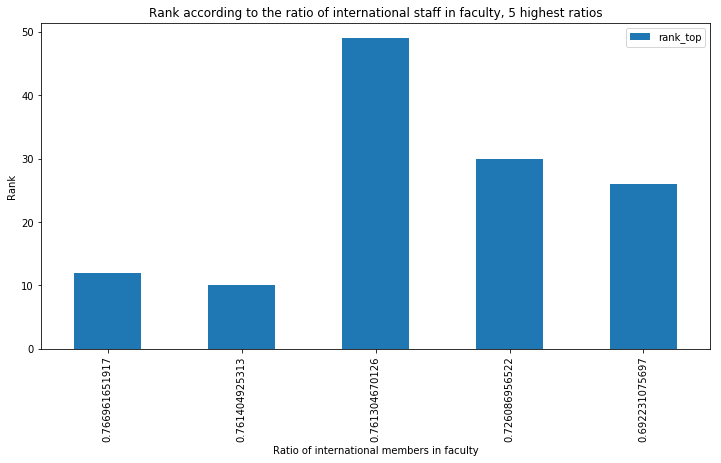

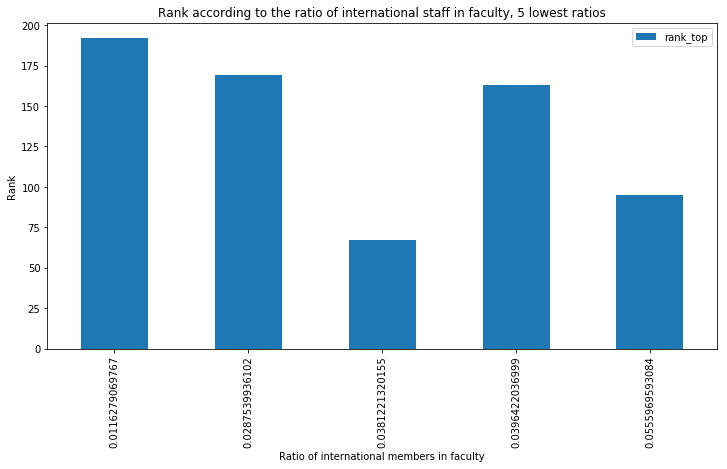

In [458]:
# Bar plots of ranking by international faculties

rank_int = df_ratio.copy()

#rank_int = rank_int.head()
rank_int_best = rank_int.sort_values('int_faculty_to_total_top', ascending=False).head()
ax1 = rank_int_best.plot(['int_faculty_to_total_top'],['rank_top'],kind = 'bar',figsize=(12,6))
ax1.set_xlabel('Ratio of international members in faculty')
ax1.set_ylabel('Rank')
ax1.set_title('Rank according to the ratio of international staff in faculty, 5 highest ratios')


rank_int_worst = rank_int.sort_values('int_faculty_to_total_top', ascending=True).head()
ax2 = rank_int_worst.plot(['int_faculty_to_total_top'],['rank_top'],kind = 'bar',figsize=(12,6))
ax2.set_xlabel('Ratio of international members in faculty')
ax2.set_ylabel('Rank')
ax2.set_title('Rank according to the ratio of international staff in faculty, 5 lowest ratios')


<span style="color:blue">The upper barplot represents the 5 highest ratios of international faculty members. It appears that all university present in this graph are on the top 50. This confirms the fact that a higher ratio of international faculty members leads to a better ranking. </span>
<span style="color:blue">On the lower graph the 5 lowest ratios are represented. It can be seen that the best rank for these ratio is around 60. </span>

# Can you find the best university taking in consideration both rankings? Explain your approach.

<span style="color:blue">We create a third ranking which is the average of the other two. In the absence of any indication that one ranking is more reputable that the other, we assign equal weight to both rankings. We opt to let universities with equal ranking values tied for a given position in the ranking without breaking the tie. We then sort the dataframe by this third ranking to obtain the following dataframe.</span>

In [459]:
ranking_average = merged_df.copy()

ranking_average = ranking_average[['rank_top','rank_times']]
# Average of rankings
ranking_average['average'] = (ranking_average['rank_top'] + ranking_average['rank_times'])/2

ranking_average.sort_values('average', ascending=True).head()

,rank_top,rank_times,average
name,,,
Stanford University,2,3,2.5
University of Cambridge,5,2,3.5
University of Oxford,6,1,3.5
Harvard University,3,6,4.5
Imperial College London,8,8,8.0


<span style="color:blue">As a result, it appears that the best university is Stanford according to our custom ranking... Although EPFL will always be first in our hearts ;-) </span>